In [29]:
import sys

from data_helper import ImageGenerator, get_train_matrices, get_test_matrices
from sklearn.cross_validation import train_test_split
from keras_helper import KerasModel
import gc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from itertools import chain

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
img_size = (64, 64)
img_channels = 3
output_size = 17

In [3]:
x_train, y_train, labels_map = get_train_matrices("../../planet-amazon-deforestation/input/train_v2.csv", "../../planet-amazon-deforestation/input/train-jpg", img_size)
X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

100%|██████████| 40479/40479 [01:35<00:00, 424.38it/s]


In [4]:
generator = ImageGenerator()
flow = generator.get_train_generator(X_train, y_train)
validation_data = (X_valid, y_valid)

In [5]:
from tensorflow.contrib.keras.api.keras.callbacks import ModelCheckpoint

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)

In [6]:
model = KerasModel(img_size)
learn_rates = [0.001]
epochs_list = [1]
train_losses, val_losses = [], []

for lr, epochs in zip(learn_rates, epochs_list):
    tmp_train_losses, tmp_val_losses, fbeta_score = model.fit(flow, epochs, lr, (X_valid, y_valid), train_callbacks=[checkpoint])
    train_losses += tmp_train_losses
    val_losses += tmp_val_losses

Epoch 1/1
5/5 [==============================] - 73s - loss: 0.9702 - acc: 0.5197 - val_loss: 2.5120 - val_acc: 0.4350


In [7]:
model.load_weights("weights.best.hdf5")
print("Weights loaded")

Weights loaded


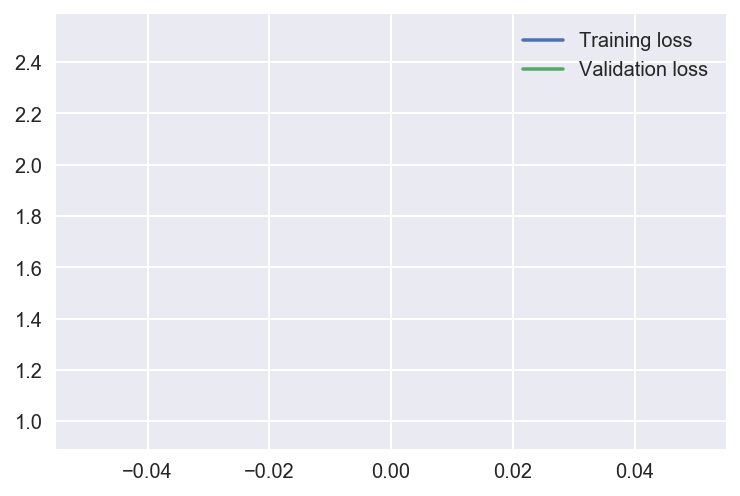

In [8]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

In [9]:
fbeta_score

0.13458996033007009

In [10]:
del x_train, y_train
gc.collect()

x_test, x_test_filename = get_test_matrices("/Users/westside/dev/python/planet-amazon-deforestation/input/test-jpg", img_size)
# Predict the labels of our x_test images
predictions = model.predict(x_test)

del x_test
gc.collect()

x_test, x_test_filename_additional = get_test_matrices("/Users/westside/dev/python/planet-amazon-deforestation/input/test-jpg-additional", img_size)
new_predictions = model.predict(x_test)

del x_test
gc.collect()

predictions = np.vstack((predictions, new_predictions))
x_test_filename = np.hstack((x_test_filename, x_test_filename_additional))
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions entry:\n{}".format(predictions.shape, 
                                                                              x_test_filename.shape,
                                                                              predictions[0]))

100%|██████████| 20522/20522 [00:44<00:00, 460.67it/s]


Predictions shape: (61191, 17)
Files name shape: (61191,)
1st predictions entry:
[  6.07769527e-02   1.78669259e-01   3.51643562e-01   5.53916931e-01
   6.76500797e-02   1.79684753e-06   9.99944806e-01   8.60570252e-01
   1.71486549e-02   9.55175459e-01   9.81331348e-01   1.06138498e-01
   2.95971194e-03   6.63977087e-01   3.39273781e-01   6.21109426e-01
   9.11373377e-01]


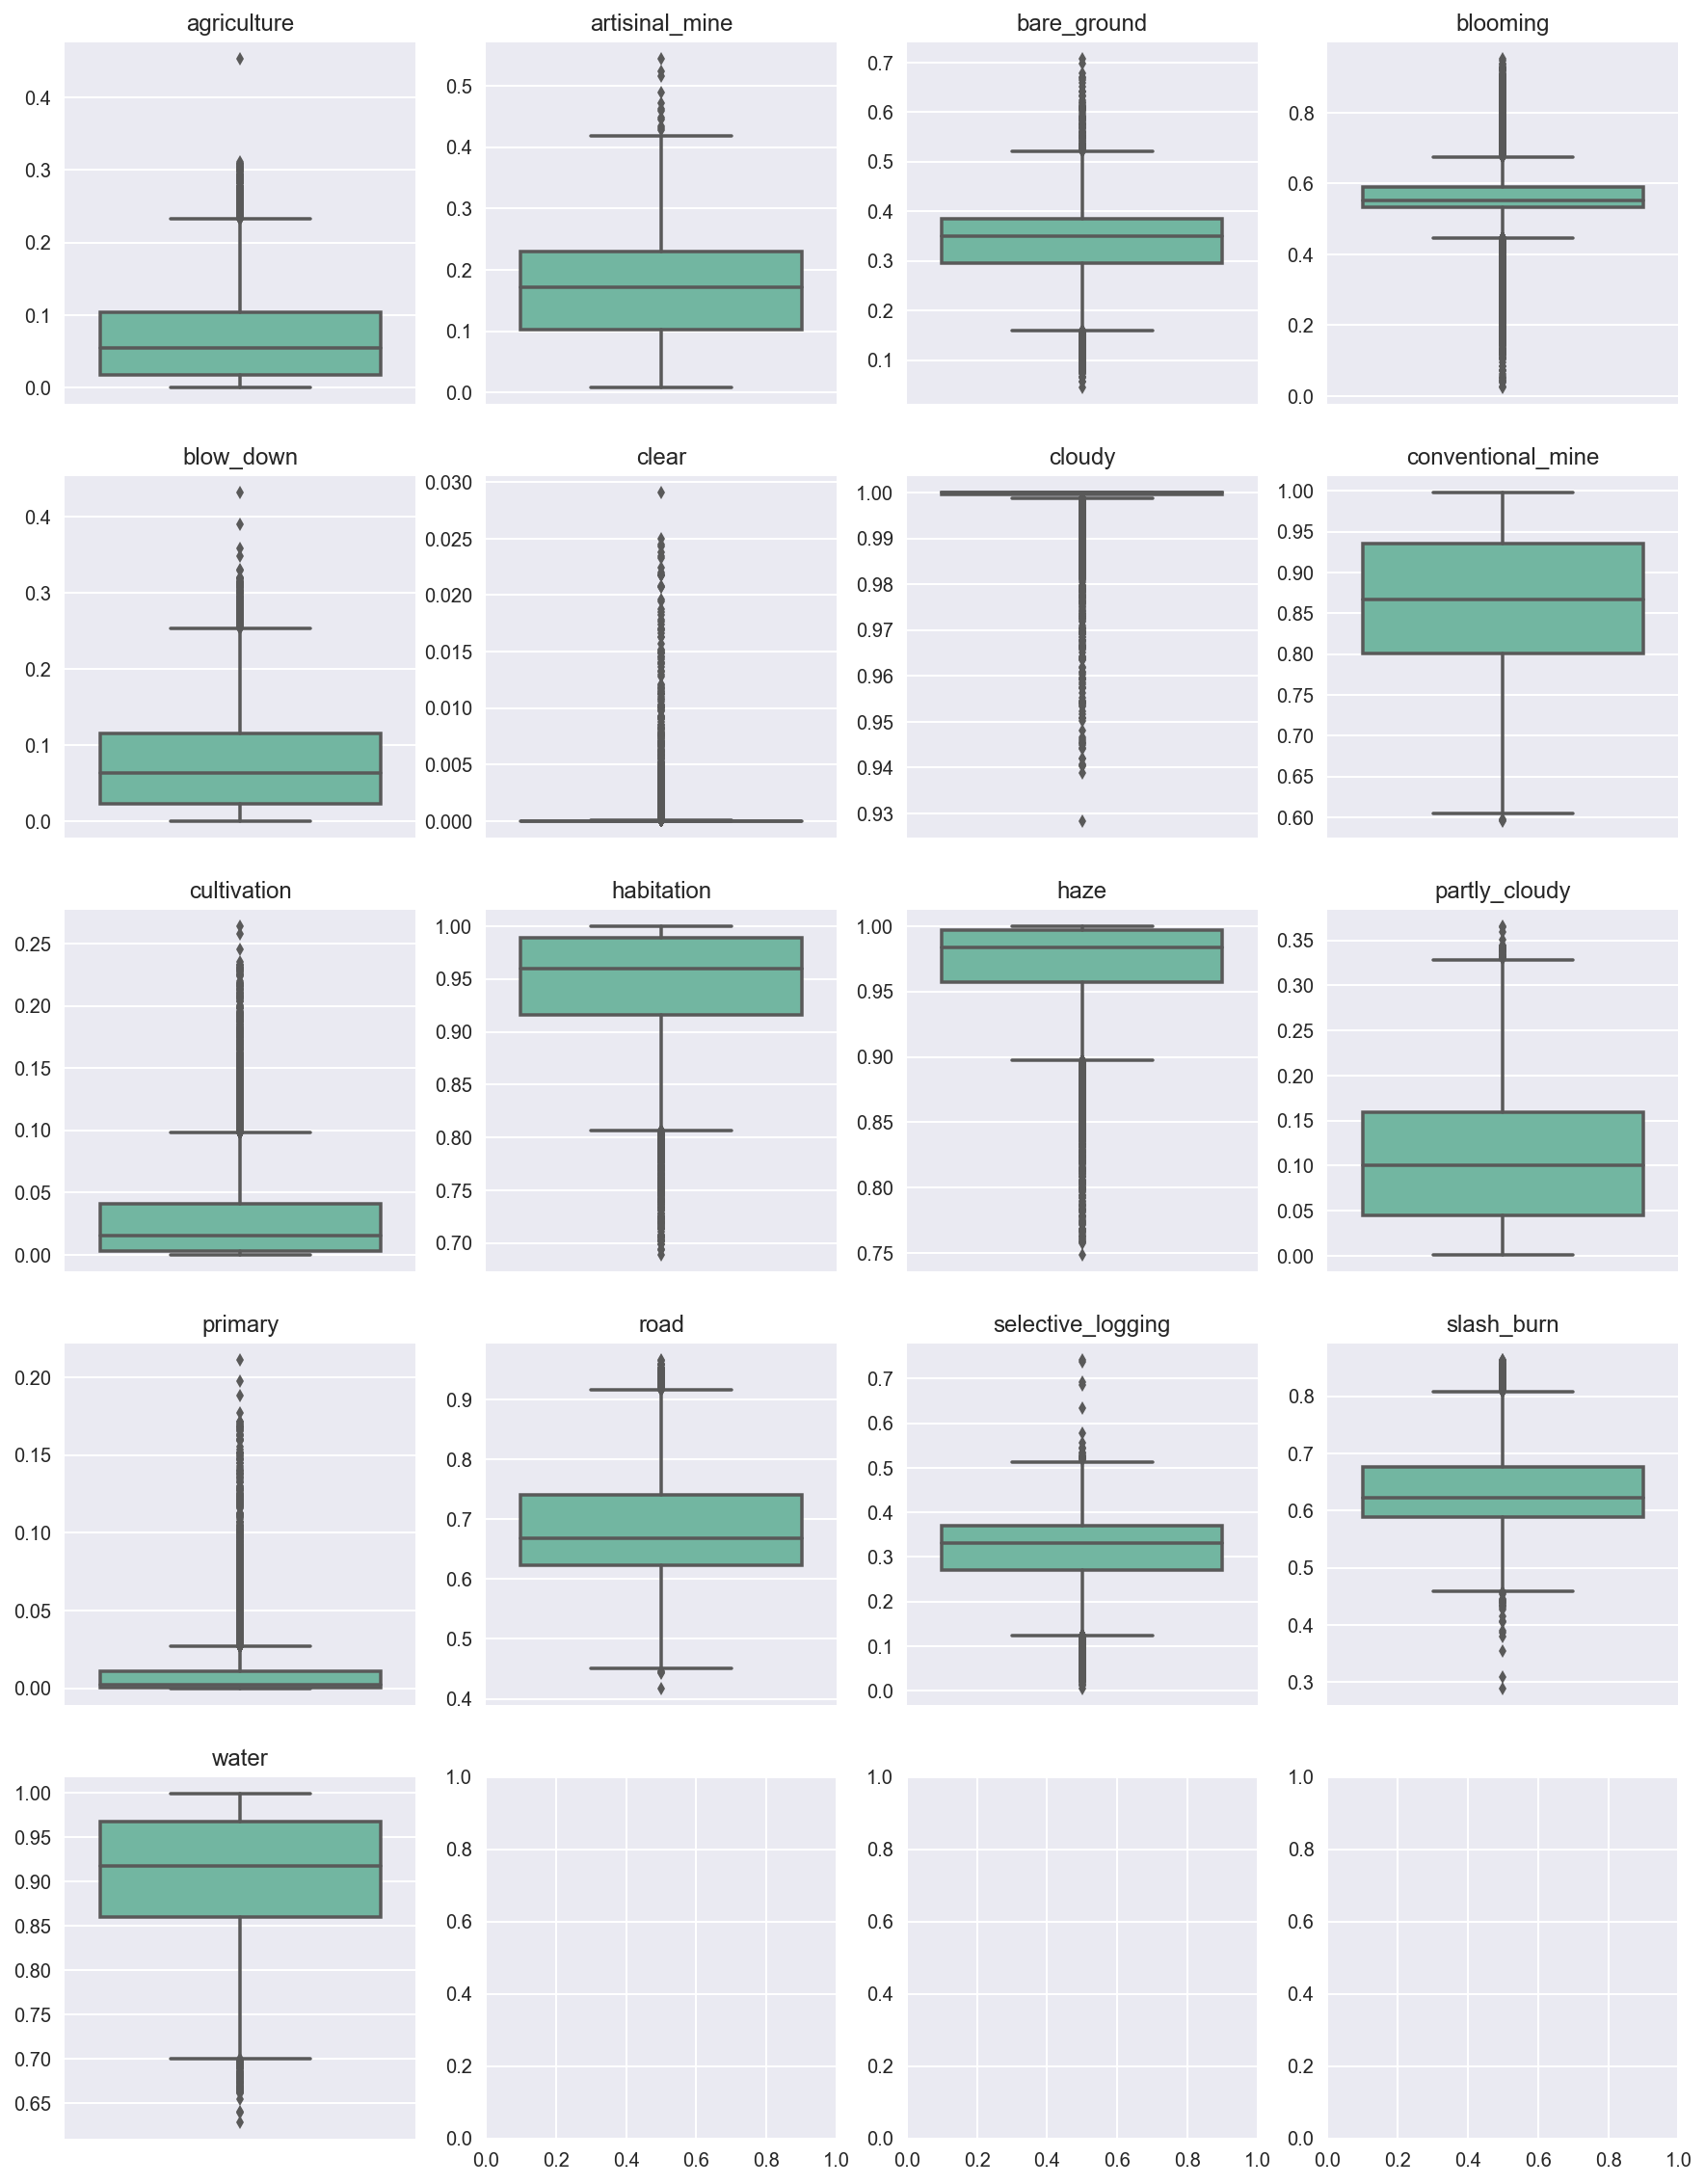

In [20]:
# For now we'll just put all thresholds to 0.2 
thresholds = [0.2] * output_size

# TODO complete
tags_pred = np.array(predictions).T
_, axs = plt.subplots(5, 4, figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    sns.boxplot(tag_vals, orient='v', palette='Set2', ax=axs[i]).set_title(labels_map[i])

In [22]:
predicted_labels = model.map_predictions(predictions, labels_map, thresholds)

In [23]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [27]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
final_df.head()

,image_name,tags
0,test_0,bare_ground blooming cloudy conventional_mine ...
1,test_1,artisinal_mine bare_ground blooming cloudy con...
2,test_10,artisinal_mine bare_ground blooming cloudy con...
3,test_100,artisinal_mine bare_ground blooming cloudy con...
4,test_1000,bare_ground blooming cloudy conventional_mine ...


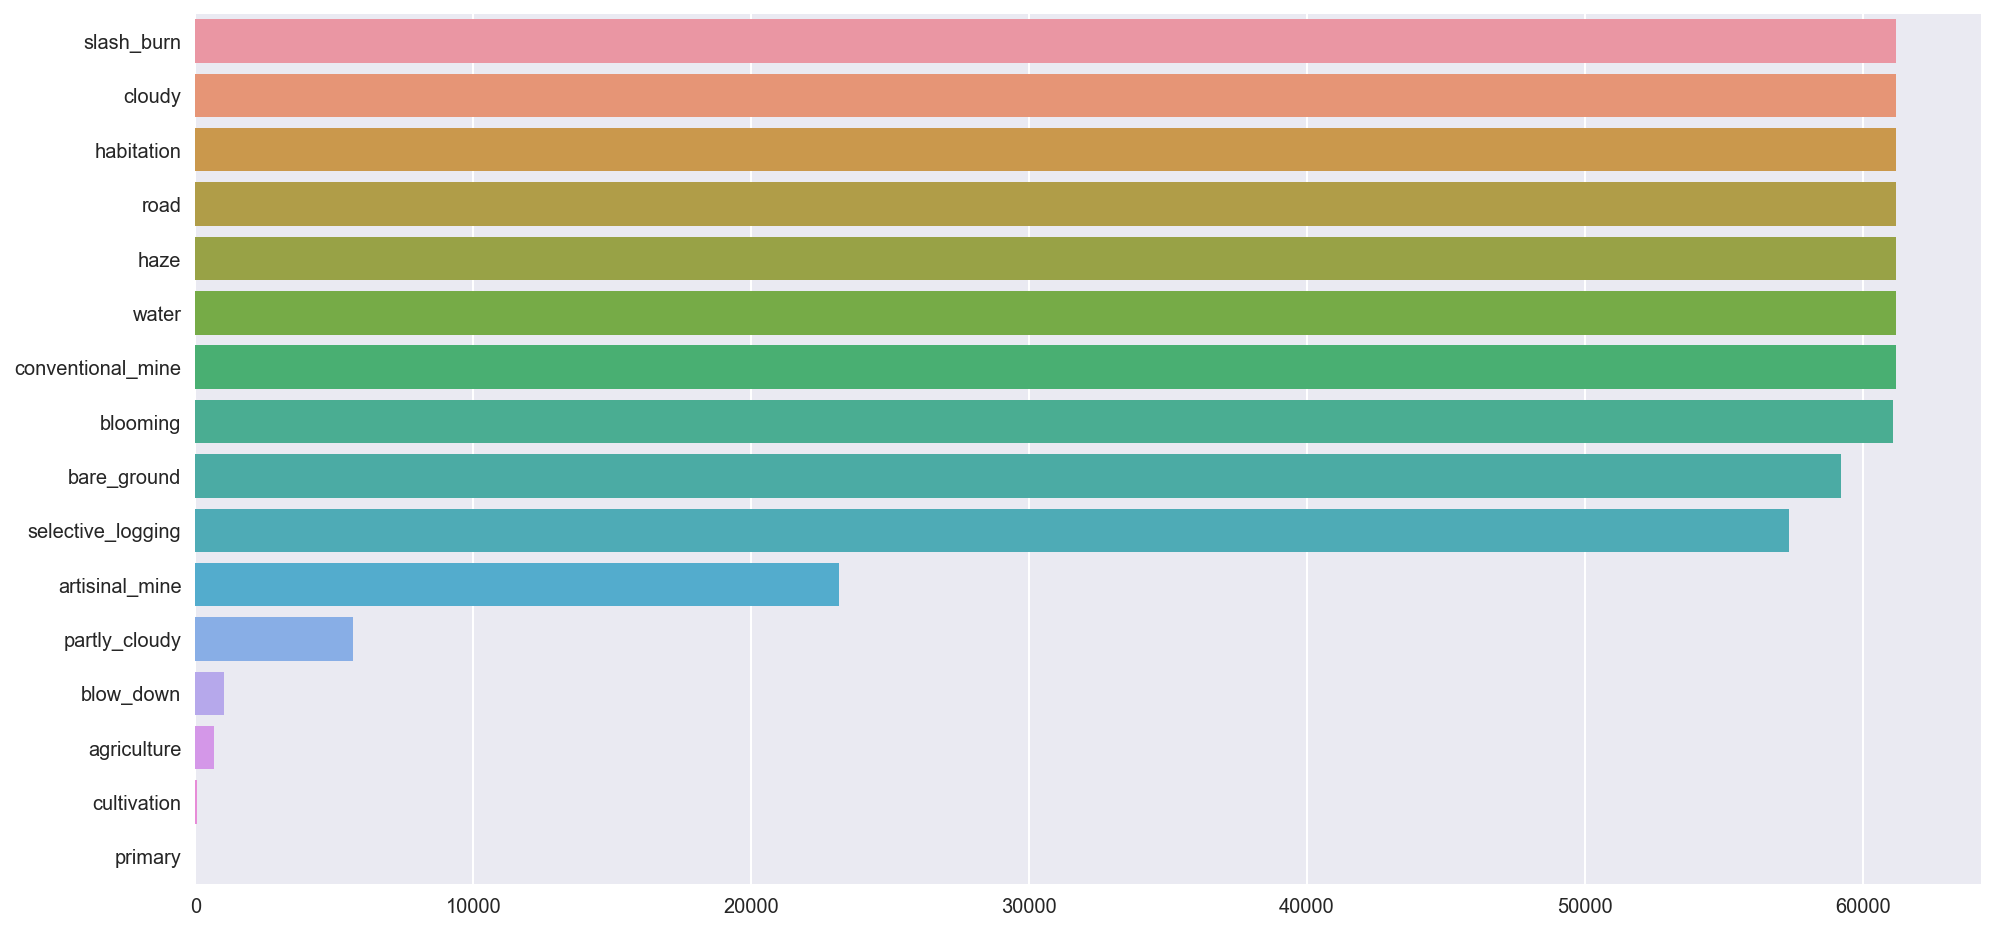

In [30]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

In [32]:
final_df.to_csv('../submission_file.csv', index=False)
model.close()